Grabbing WebIDs ...
WebID collection complete!
16:14:14: Sending API request... Chunk 1 of 1
16:14:16: Response recieved for 1 tags! (1.7)


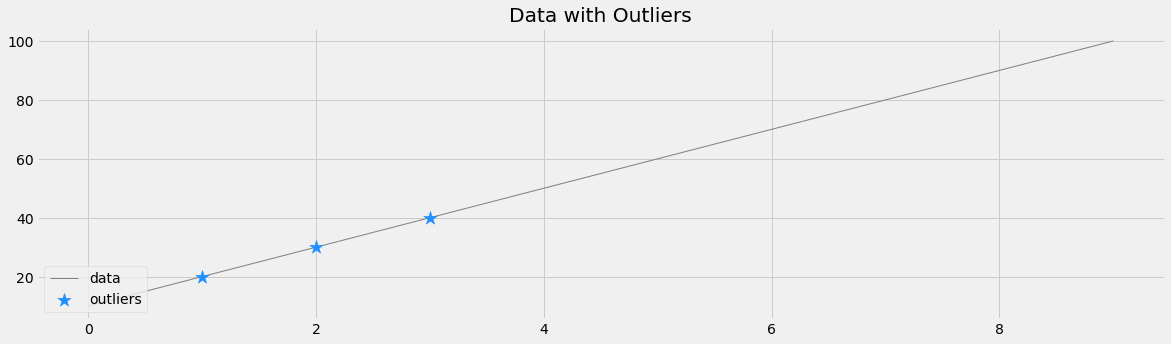

In [53]:
import sys
"""Put the path to the eco-tools folder in the following line... should look something like this one below"""
sys.path.append(r"C:\\Users\\ejgoldbe\\Desktop\\eco-tools/") #path to PI CLient
#if not working: pip install requests-kerberos Desktop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from ecotools.pi_client import pi_client
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.lines import Line2D
from matplotlib import style
style.use("fivethirtyeight")
pc = pi_client(root='readonly')
points = pc.search_by_point("GBSF_Electricity_Demand_kBtu")
second_points = pc.search_by_point('aitit4045*')
start = "06-28-2017"
end = "*"
interval = '1h' #can be 1d 2d for days or 1s for seconds or 1m for minutes
calculation = 'summary'
from statsmodels.tsa.seasonal import seasonal_decompose
df = pc.get_stream_by_point(points, start = start, 
                            end = end, calculation=calculation,
                            interval=interval)
series = pd.Series(df.iloc[:, 0], index = df.index)
series = series[~series.isnull()]

    
        
def plot_data(data, xlabel="Time", ylabel=None, title="Point Values", color="gray", linewidth=1):
    if isinstance(xlabel, str) is False or isinstance(title, str) is False or isinstance(color, str) is False:
        raise TypeError("xlabel, title, and color need to be of type str.")
    else:
    #if ylabel is not None, check it is also of type str
        if ylabel is not None and isinstance(ylabel, str) is False:
            raise TypeError("ylabel needs to be of type str.")
        else:
            #check that linewidth is an integer greater than 0
            if isinstance(linewidth, int) is False or linewidth <= 0:
                raise ValueError("Linewidth needs to be an integer greater than 0.")
            else:
                plt.figure(figsize=(18, 5))
                plt.plot(data.index, data.values, color = color, linewidth=linewidth)
                plt.xlabel(xlabel)
                plt.ylabel(ylabel)
                plt.title(title)
                plt.show()

                
def plot_data_with_anomalies(data, indexes):
    #this function plots data and outliers using only the integer indexes of outliers
    outlier_dates = []
    outlier_values = []
    if isinstance(data, pd.Series) is False:
        raise TypeError("Your data needs to be in Series format.")
    else:
        #check that their second argument is a list 
        if isinstance(indexes, list) is False:
            raise TypeError("Your outlier indexes need to be in a list.")
        else:
            #check that their Series data is numeric, else we can't plot its values
            v = data.values
            is_numeric = np.issubdtype(v.dtype, np.number)
            if is_numeric is False:
                raise TypeError("Your Series data needs to be numeric.")
            else:
                #check that outlier indexes are all numeric
                if all((isinstance(i, int) for i in indexes)) is False:
                    raise TypeError("List of outlier indexes need to all be integers.")
                else:
                #plot our data
                    plt.figure(figsize = (18, 5))
                    plt.plot(data.index, data.values, color = 'gray', linewidth=1, label = 'data', zorder=1)
                    #loop through our outlier indexes
                    for i in indexes:
                        outlier_date = data.index[i]
                        outlier_value = data.values.tolist()[i]
                        outlier_dates.append(outlier_date)
                        outlier_values.append(outlier_value)
                    outliers = pd.Series(outlier_values, index=outlier_dates)
                    plt.scatter(outliers.index, outliers.values, color='dodgerblue', marker='*', s=200, label='outliers', zorder=2)
                    plt.legend(loc = 'lower left')
                    plt.title("Data with Outliers")
                    plt.show()

                    
def plot_data_with_anomalies(data, outliers):
    #this function passes in outliers as a Series
    if isinstance(outliers, pd.Series) is False or isinstance(data, pd.Series) is False:
        raise TypeError("Your data and outliers need to be in Series format.")
    else:
        #check that both data and outlier Series are numeric, i.e. we can't plot outlier strings
        a = data.values
        b = outliers.values
        is_numeric = np.issubdtype(a.dtype, np.number)
        is_numeric_two = np.issubdtype(b.dtype, np.number)
        if is_numeric is False or is_numeric_two is False:
            raise TypeError("Both Series need to have numeric values.")
        else:
            plt.figure(figsize=(18, 5))
            plt.plot(data.index, data.values, color = 'gray', linewidth=1, label='data', zorder=1)
            plt.scatter(outliers.index, outliers.values, color='dodgerblue', marker='*', s=200, label='outliers', zorder=2)
            plt.legend(loc = 'lower left')
            plt.title("Data with Outliers")
            plt.show()



def clean_data(data, threshold):
    if isinstance(data, pd.Series) is False:
        raise TypeError("Your data needs to be in a Series format.")
    else:
        #the data is in a Series, check that it is of type numeric
        v = data.values
        is_numeric = np.issubdtype(v.dtype, np.number)
        if is_numeric is False:
            raise TypeError("Your Series data needs to be numeric.")
        else:
         #the data is in the correct format, check that the threshold is an int
            if isinstance(threshold, int) is False:
                raise TypeError("Your passed threshold needs to be an int.")
            else:
                #actually clean the data
                cleaned_data = data[data.values > threshold]
    return cleaned_data


def clean_data_iqr(data, threshold=2.0):
    #check that the data is a series
    if isinstance(data, pd.Series) is False:
        raise TypeError("Your data needs to be in series format.")
    else:
    #check that their threshold is a float or int
        if isinstance(threshold, int) is False and isinstance(threshold, float) is False:
            raise TypeError("Threshold needs to be either a float or int.")
        else:
            #proceed
            q1 = np.percentile(data,25)
            q3 = np.percentile(data,75)
            iqr = q3 - q1
            lower_bound = q1 -(threshold * iqr)
            upper_bound = q3 +(threshold * iqr) 
            print("lower_bound: %f" %lower_bound,"and","upper_bound: %f" %upper_bound)
            #clean the data
            data = data[data.values > lower_bound]
            cleaned_data = data[data.values < upper_bound]
    return cleaned_data   
    
 
    
def split_data(data, split = 0.7):
    #check that our data is still a Series
    if isinstance(data, pd.Series) is False:
        raise TypeError("Your data needs to be in a Series format.")
    else:
        #check that split is a float value
        if isinstance(split, float) is False:
            raise TypeError("Your split value needs to be a float.")
        else:
        #check that split is 0.0 < x < 1.0
            if not 0.0 < split < 1.0:
                raise ValueError("Split value needs to be between 0.0 and 1.0")
            else:
                #split data in time format, not randomly shuffled
                length_training = split * len(data)
                length_training = int(round(length_training, 0))
                training = data[0:length_training]
                testing = data[length_training:len(data)]
    return training, testing
                

def decompose_data(data, method = "bfill"):
    #ensure that our data is in the proper format
    if isinstance(data, pd.Series) is False:
        raise TypeError("Your data needs to be in a Series format.")
    else:
        #check that their data has a datetime index
        if type(data.index) is not pd.core.indexes.datetimes.DatetimeIndex:
            raise TypeError("Series index needs to be in DateTime format.")
        else:
        #ensure data is in hourly format
        #check that their method is one of bfill or ffill
            if method is not "bfill" and method is not "ffill":
                raise TypeError("Method needs to be of type either bfill or ffill.")
            else:
                #may need to add check that data.values are of type int
                hourly = data.asfreq("H", method=method)
                #decompose the data
                result = seasonal_decompose(hourly)
                trend = result.trend
                trend = result.trend.fillna(result.trend.mean())
                seasonality = result.seasonal
                seasonality = seasonality.fillna(seasonality.mean())
                resid = result.resid
                resid = resid.fillna(resid.mean())
                decomposed_df = pd.DataFrame(dict(Data = hourly.values, Trend = trend.values, 
                                                 Seasonality = seasonality.values, Noise = resid.values))
                #make the index using any one of the Timestamps, since they are equivalent
                decomposed_df.index = hourly.index    
                #plot the data as part of what is returned
                decomposed_df.plot()
            
    return decomposed_df
    
#a function that combines all three, returns decomposed of clean training and non-cleaned testing      
def split_clean_and_decompose(data, method = "bfill", split_percentage = 0.7, threshold=2500):
    #ensure that our data is in the proper format
    if isinstance(data, pd.Series) is False:
        raise TypeError("Your data needs to be in a Series format.")
    else:
        #check that their data has a datetime index, or else we can't decompose it
        if type(data.index) is not pd.core.indexes.datetimes.DatetimeIndex:
            raise TypeError("Series index needs to be in DateTime format.")
        else:
            #ensure that data is of type numeric for cleaning - i.e. the Series is not strings, or else we can't clean it
            v = data.values
            is_numeric = np.issubdtype(v.dtype, np.number)
            if is_numeric is False:
                raise TypeError("Your Series data needs to be numeric.")
            else:
          #ensure data is in hourly format
          #check that their method is one of bfill or ffill
                if method is not "bfill" and method is not "ffill":
                    raise TypeError("Method needs to be of type either bfill or ffill.")
                else:
                    #check that split percentage is a float 0.0 < x < 1.0, or else we can't split it
                    if isinstance(split_percentage, float) is False:
                        raise TypeError("Split percentage needs to be a float.")
                    else:
                        if not 0.0 < split_percentage < 1.0:
                            raise ValueError("Split value needs to be between 0.0 and 1.0")
                        else:
                        #check that threshold is an int
                            if isinstance(threshold, int) is False:
                                raise TypeError("Your passed threshold needs to be an int.")
                            else:
                            #split the data
                                length_training = split_percentage * len(data)
                                length_training = int(round(length_training, 0))
                                training = data[0:length_training]
                                testing = data[length_training:len(data)]
                                #clean the training data
                                training = training[training.values > threshold]
                                #recombine to decompose them
                                combined = pd.concat([training, testing])    
                                #may need to add check that data.values are of type int
                                hourly = combined.asfreq("H", method=method)
                                #decompose the data
                                result = seasonal_decompose(hourly)
                                trend = result.trend
                                trend = trend.fillna(result.trend.mean())
                                seasonality = result.seasonal
                                seasonality = seasonality.fillna(seasonality.mean())
                                resid = result.resid
                                resid = resid.fillna(resid.mean())
                                decomposed_df = pd.DataFrame(dict(Data = hourly.values, Trend = trend.values, 
                                                 Seasonality = seasonality.values, Noise = resid.values))
                                #make the index using any one of the Timestamps, since they are equivalent
                                decomposed_df.index = hourly.index    
                                #plot the data as part of what is returned
                                decomposed_df.plot(figsize = (20, 10))
            
    return decomposed_df



  

    

# Example Using the First Three Functions

,Data,Trend,Seasonality,Noise
Timestamp,,,,
2017-06-28 00:00:00,2676.141823,2846.35974,-178.830361,0.016475
2017-06-28 01:00:00,2660.262893,2846.35974,-192.911493,0.016475
2017-06-28 02:00:00,2660.319187,2846.35974,-199.374782,0.016475
2017-06-28 03:00:00,2679.009611,2846.35974,-203.230484,0.016475
2017-06-28 04:00:00,2692.048994,2846.35974,-203.986499,0.016475


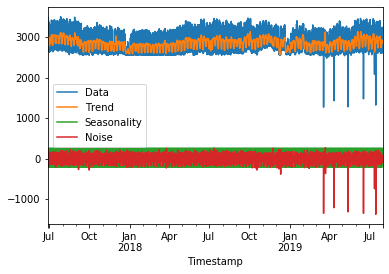

In [20]:
#split data
training, testing = split_data(series, split=0.8)
cleaned_training = clean_data(training, threshold=2550)
combined_data = pd.concat([cleaned_training, testing])
decomposed_data = decompose_data(combined_data)
display(decomposed_data.head(5))

# Example Using the Super-Savvy 3-for-1 Function

,Data,Trend,Seasonality,Noise
Timestamp,,,,
2017-06-28 00:00:00,2676.141823,2846.35974,-178.830361,0.016475
2017-06-28 01:00:00,2660.262893,2846.35974,-192.911493,0.016475
2017-06-28 02:00:00,2660.319187,2846.35974,-199.374782,0.016475
2017-06-28 03:00:00,2679.009611,2846.35974,-203.230484,0.016475
2017-06-28 04:00:00,2692.048994,2846.35974,-203.986499,0.016475


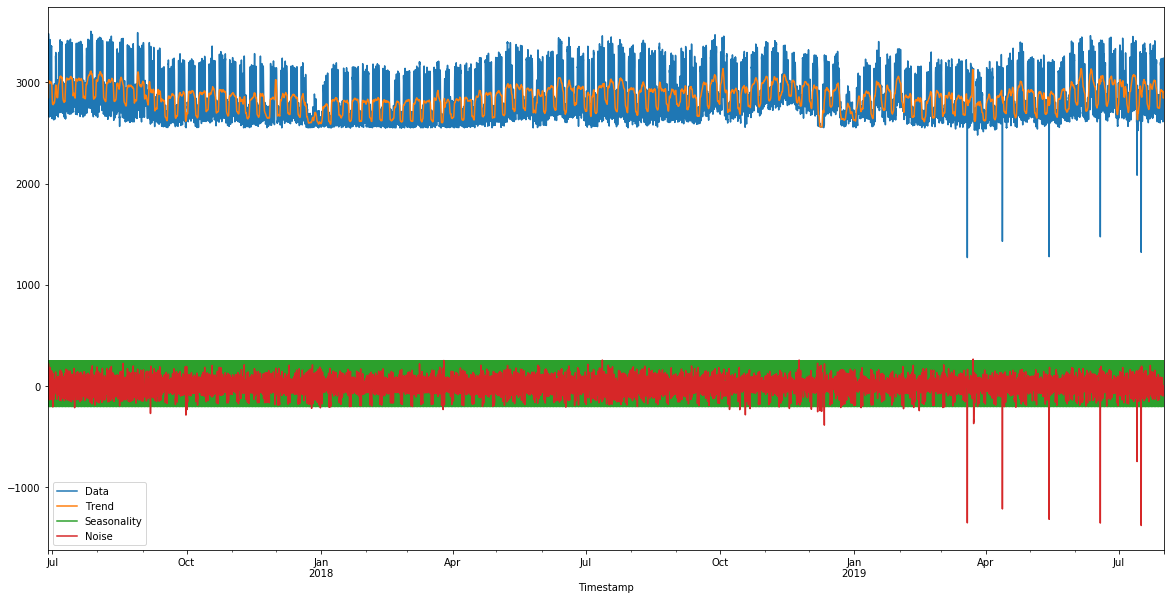

In [25]:
decomposed_data_two = split_clean_and_decompose(series, split_percentage=0.8, threshold=2550)
display(decomposed_data_two.head(5))